In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import fstd2nc
import cftime

In [2]:
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=4, # The number of cores you want
    memory='128 GB', # Amount of memory
    processes=40, # How many processes
    queue='development', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=40:mem=128GB', # Specify resources
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(1)

# Setup your client
client = Client(cluster)

/home/ncs001/.conda/envs/gem-vis/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 10645 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://10.102.15.229:9731' processes=0 threads=0, memory=0 B>

In [4]:
def plot_yg_fields(yin_rlon, yin_rlat, yin_field, yan_rlon, yan_rlat, yan_field, **kwargs):
    '''Create a compound figure of Yin/Yang panels, plotted in rotated coordinates.
    '''
    fig = plt.figure(figsize=(8,14))

    rotated_yan = ccrs.RotatedPole(pole_latitude=8.050,pole_longitude=352.579, central_rotated_longitude=180)
    rotated_yin = ccrs.RotatedPole(pole_latitude=31.758,pole_longitude=87.597)
    data_crs = ccrs.PlateCarree()

    axes_class = (GeoAxes,
                      dict(projection=data_crs))


    grid = AxesGrid(fig, 111, axes_class=axes_class,
                        nrows_ncols=(2, 1),
                        axes_pad=0.25,
                        cbar_location='right',
                        cbar_mode='single',
                        cbar_pad=0.1,
                        cbar_size='3%',
                        label_mode='')  # note the empty label_modead=0.05

    axl = grid[0]
    axl.contourf(yin_rlon, yin_rlat, yin_field,transform=rotated_yin, **kwargs)
    axl.coastlines(linewidth=0.1)  

    axr = grid[1]
    cm = axr.contourf(yan_rlon+180, yan_rlat, yan_field, transform=rotated_yan, **kwargs)
    axr.coastlines(linewidth=0.1)
    grid.cbar_axes[0].colorbar(cm,extend='both')

In [5]:
# These are outputs from a CanAM-GEM AMIP run on the 303x115 grid
ds_amip_yin = xr.open_dataset('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/BEGO_2003010100_00000006_yin.nc')
ds_amip_yan = xr.open_dataset('/home/ncs001/site5/gemdc-tests/yy_out/yy_out_ng/BEGO_2003010100_00000006_yan.nc')

In [6]:
ds_cpl_his1 = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/cancpl_gem_test_apply_windstress_3062860/work/cpl_history.nc',
                              chunks={'time':100})        # v1 geophy . Nemo based with threshold


ds_cpl_his2 = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/cancpl_gem_test_1504518/work/cpl_history.nc',
                              chunks={'time':100})        # v2 geophy . Nemo based without threshold


ds_cpl_his3 = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/cancpl_gem_test_old_landmask_2600947/work/cpl_history.nc',
                              chunks={'time':100})        # v0 geophy . John based with threshold

ds_cpl_his4 = xr.open_dataset('/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/tmp_turnoffsrcmask_cancpl_gem_test_96928/work/cpl_history.nc',
                              chunks={'time':100})        # run without source masking on nemo remap                          

FileNotFoundError: [Errno 2] No such file or directory: b'/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/cancpl_gem_test_apply_windstress_3062860/work/cpl_history.nc'

In [9]:
ds_cpl_his1 = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/maestro/gs-rpt-cpl03/gridpt/data/mc_gs-rpt-cpl03_1970_m01_cplhist.nc.001', 
                              chunks={'time':100})
ds_cpl_his2 = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/maestro/gs-rpt-cpl04/gridpt/data/mc_gs-rpt-cpl04_1970_m01_cplhist.nc.001', 
                              chunks={'time':100})


In [10]:
%%time
ds_cpl_mean = ds_cpl_his1.mean(dim='time').compute(scheduler=client)

CPU times: user 5.54 s, sys: 236 ms, total: 5.77 s
Wall time: 34.2 s


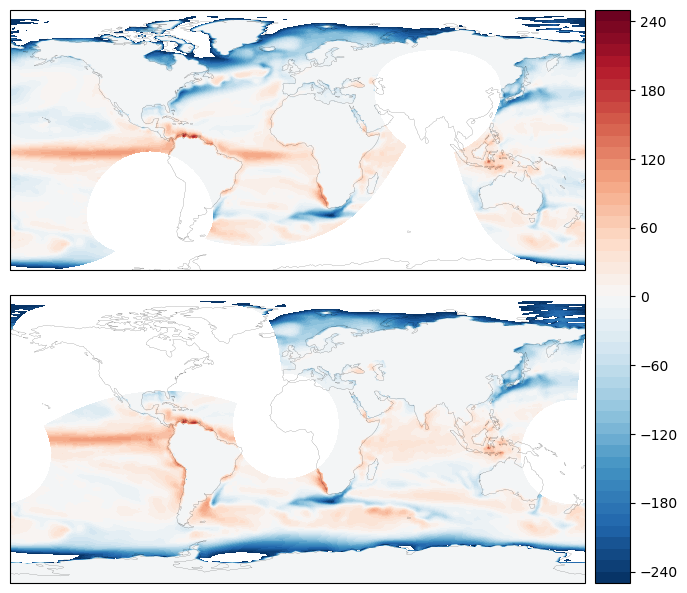

In [8]:
# Use AMIP rlon/rlat along with the coupler history file fields to make sensible plots
# For the last step
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his1.BEGO_atm_yin.mean(dim='time').compute(scheduler=client), 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his1.BEGO_atm_yang.mean(dim='time').compute(scheduler=client), 
               cmap='RdBu_r', levels=np.arange(-250,260,10))

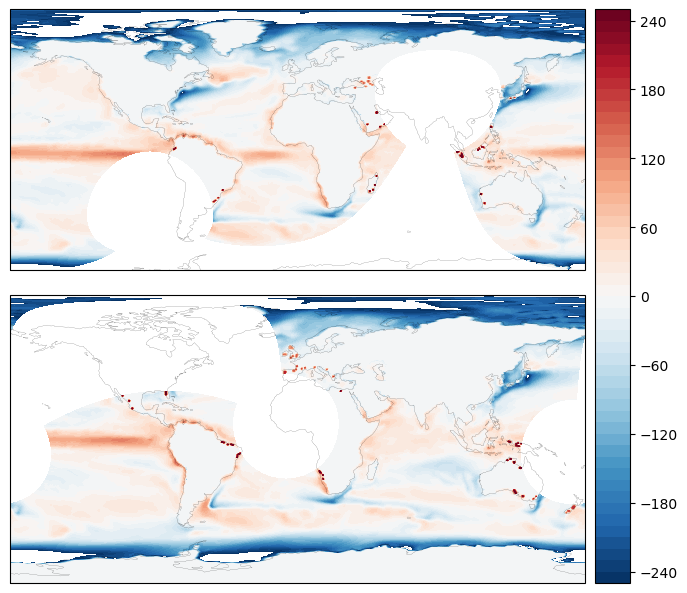

In [8]:
# Use AMIP rlon/rlat along with the coupler history file fields to make sensible plots
# For the last step
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his2.BEGO_atm_yin.mean(dim='time').compute(scheduler=client), 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his2.BEGO_atm_yang.mean(dim='time').compute(scheduler=client), 
               cmap='RdBu_r', levels=np.arange(-250,260,10))

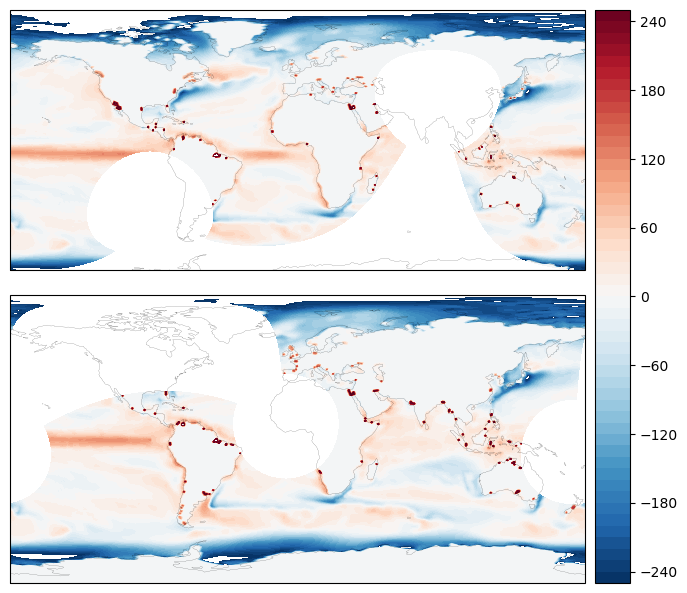

In [9]:
# Use AMIP rlon/rlat along with the coupler history file fields to make sensible plots
# For the last step
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his3.BEGO_atm_yin.mean(dim='time').compute(scheduler=client), 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his3.BEGO_atm_yang.mean(dim='time').compute(scheduler=client), 
               cmap='RdBu_r', levels=np.arange(-250,260,10))

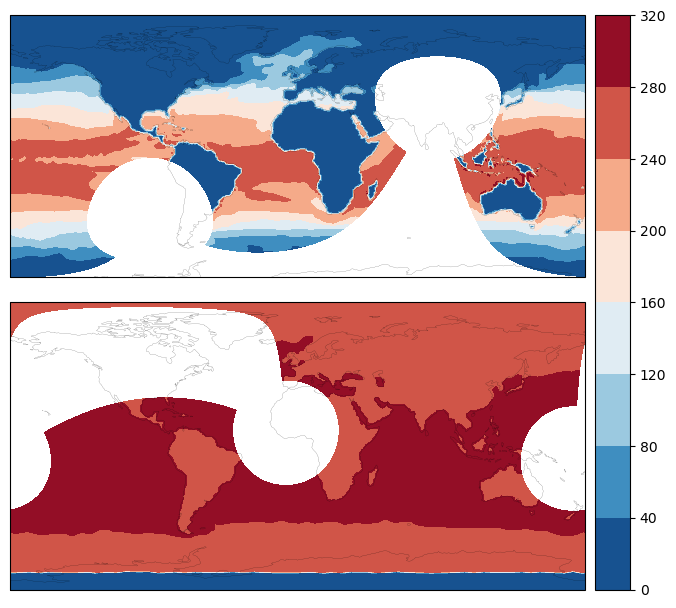

: 

In [13]:
# Use AMIP rlon/rlat along with the coupler history file fields to make sensible plots
# For the last step
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_cpl_his4.GT_atm_yin.isel(time=300),#.compute(scheduler=client), 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_cpl_his4.GT_atm_yang.isel(time=300),#.compute(scheduler=client), 
               cmap='RdBu_r')

## Try to look at spots in timeseries. First hone in on a spot to find its i,j

In [21]:
yan_mean=ds_cpl_his1.BEGO_atm_yang.mean(dim='time').compute(scheduler=client).persist()

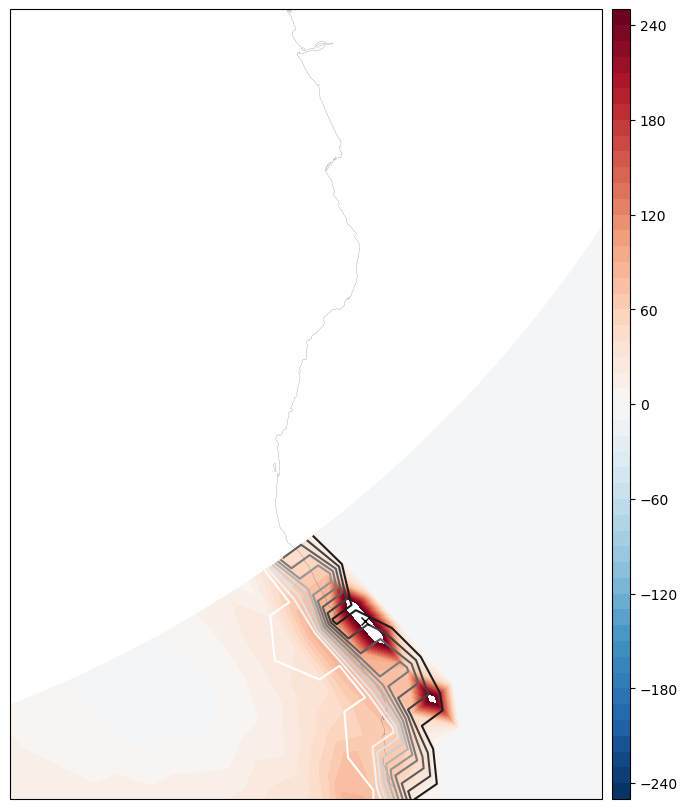

In [39]:
rotated_yan = ccrs.RotatedPole(pole_latitude=8.050,pole_longitude=352.579, central_rotated_longitude=180)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8,14))

grid = AxesGrid(fig, 111, axes_class=axes_class,
                        nrows_ncols=(1, 1),
                        axes_pad=0.25,
                        cbar_location='right',
                        cbar_mode='single',
                        cbar_pad=0.1,
                        cbar_size='3%',
                        label_mode='')  # note the empty label_modead=0.05

axr = grid[0]
cm = axr.contourf(ds_amip_yan.rlon+180, ds_amip_yan.rlat, yan_mean, transform=rotated_yan, 
                  cmap='RdBu_r', levels=np.arange(-250,260,10))

axr.contour(ds_amip_yan.rlon+180, ds_amip_yan.rlat, ds_cpl_his1.flno_atm_yang, transform=rotated_yan, 
            levels=np.arange(0,1.1,0.1), cmap='Greys')
axr.coastlines(linewidth=0.1)
axr.set_extent([5,20,-25,-5])
axr.plot(14, -20.5, 'kx', transform=data_crs)
grid.cbar_axes[0].colorbar(cm,extend='both')

In [69]:
slice(155,157)

slice(155, 157, None)

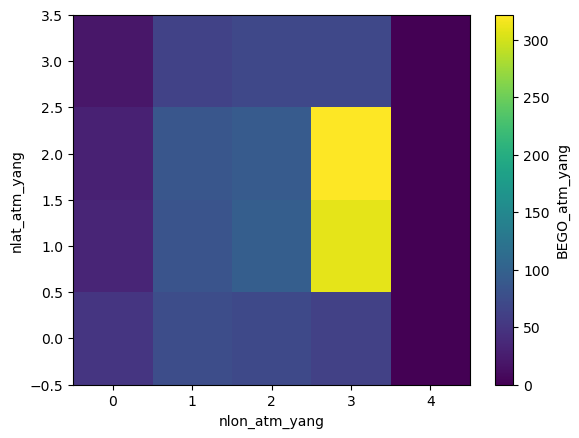

In [67]:
yan_mean.isel(nlon_atm_yang=slice(152,157), nlat_atm_yang=slice(110,114)).plot()
plt.plot()

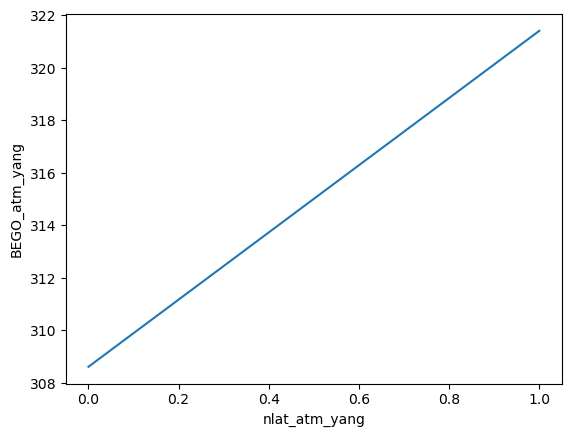

In [73]:
yan_mean.isel(nlon_atm_yang=slice(155,156), nlat_atm_yang=slice(111,113)).plot()


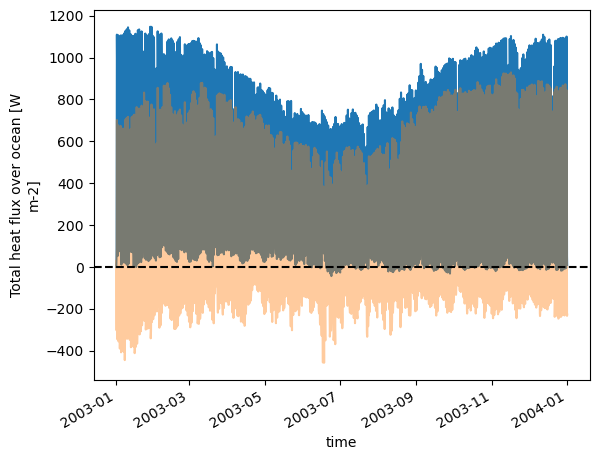

In [83]:
ds_cpl_his1.BEGO_atm_yang.isel(nlon_atm_yang=155, nlat_atm_yang=112).plot()
ds_cpl_his1.BEGO_atm_yang.isel(nlon_atm_yang=154, nlat_atm_yang=112).plot(alpha=0.4)
plt.axhline(0,color='k', linestyle='--')

(12053.0, 12056.0)

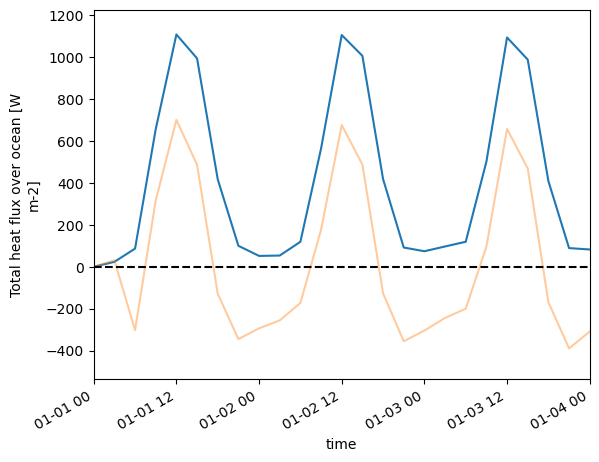

In [84]:
ds_cpl_his1.BEGO_atm_yang.isel(nlon_atm_yang=155, nlat_atm_yang=112).plot()
ds_cpl_his1.BEGO_atm_yang.isel(nlon_atm_yang=154, nlat_atm_yang=112).plot(alpha=0.4)
plt.axhline(0,color='k', linestyle='--')
plt.gca().set_xlim([ds_cpl_his1.time[0], ds_cpl_his1.time[24]])

(12053.0, 12056.0)

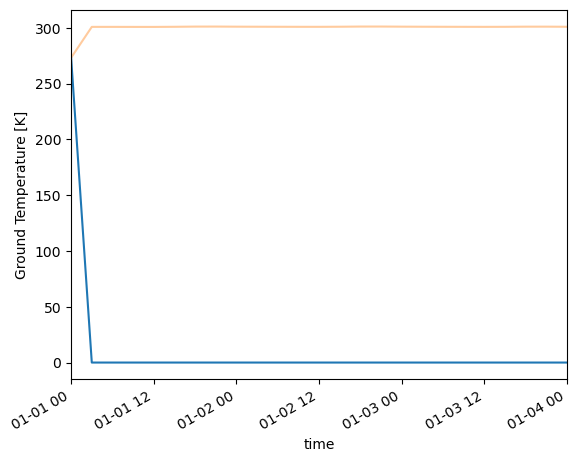

In [86]:
ds_cpl_his1.GT_atm_yang.isel(nlon_atm_yang=155, nlat_atm_yang=112).plot()
ds_cpl_his1.GT_atm_yang.isel(nlon_atm_yang=154, nlat_atm_yang=112).plot(alpha=0.4)
#plt.axhline(0,color='k', linestyle='--')
plt.gca().set_xlim([ds_cpl_his1.time[0], ds_cpl_his1.time[24]])

In [85]:
ds_cpl_his1

<xarray.Dataset>
Dimensions:               (time: 2921, nlat_atm_yin: 115, nlon_atm_yin: 303,
                           nlat_atm_yang: 115, nlon_atm_yang: 303,
                           nlat_ocn: 292, nlon_ocn: 362)
Coordinates:
  * time                  (time) datetime64[ns] 2003-01-01 ... 2004-01-01
Dimensions without coordinates: nlat_atm_yin, nlon_atm_yin, nlat_atm_yang,
                                nlon_atm_yang, nlat_ocn, nlon_ocn
Data variables: (12/79)
    lon_atm_yin           (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lat_atm_yin           (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lon_atm_yang          (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lat_atm_yang          (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lon_ocn               (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat_ocn               (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    ...                    ...
    god_weights_atm_yin   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    flno_atm_yin          (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    cell_area_atm_yang    (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    god_weights_atm_yang  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    flno_atm_yang         (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    nemo_tmask            (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
Attributes:
    CCCma_runid:  default

In [2]:
# These files contain YG data stacked back to back
ds_pm2 = fstd2nc.Buffer("/space/hall6/sitestore/eccc/crd/ccrn/ccrn_tmp/rcs001/cancpl_gem_test_2206422/output/cfg_0000/laststep_0000000000/000-000/pm2003010100-000-000_00000001n").to_xarray()

Found 1 RPN standard file(s)
Read(999) !!   X  GCM18               3     105     1  000000000        83519     50521         0        0        0  E 64  X  5005     0   300  1500
Read(999) ^>   X  GCM18             861       1     1  304661600        83519     50521         1        0        0  E 32  F     1     0     0     0


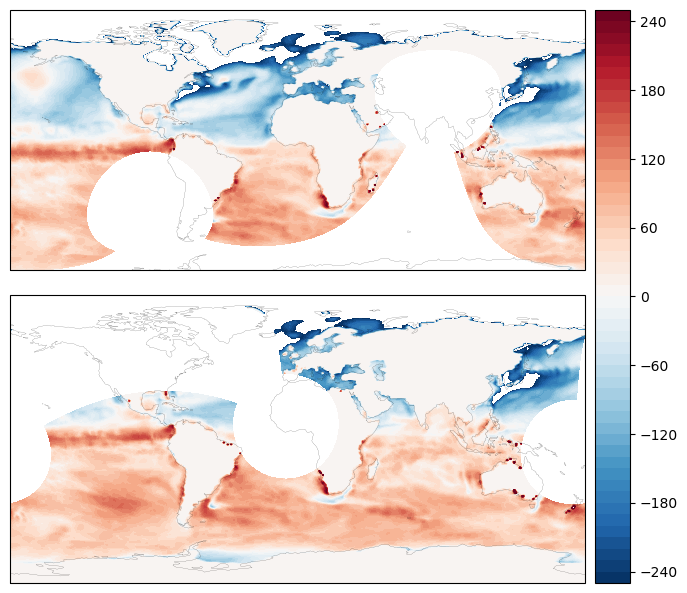

In [13]:
plot_yg_fields(ds_amip_yin.rlon, ds_amip_yin.rlat, ds_pm2.BEGO.isel(y=slice(0,115)).mean(dim='time').squeeze(), 
               ds_amip_yan.rlon, ds_amip_yan.rlat, ds_pm2.BEGO.isel(y=slice(115,230)).mean(dim='time').squeeze(), 
               cmap='RdBu_r', levels=np.arange(-250,260,10))

## A more general look around

In [ ]:
%%time
ds_cpl_mean = ds_cpl_his1.mean(dim='time').compute(scheduler=client)

In [ ]:
ds_cpl_mean